# Abnormal Household Electrical Consumption Detection
According to Y.Tang, M.Wen and et. al[$^1$](The Abnormal Electricity Consumption Detection System Based on the Outlier Behavior Pattern Recognition), stealing and leakagage of electricity is a challenging problem to power supply enterprises. Hence there is a need to formulate a capability in detecting abnormal electrical consumption. In the paper, it propose the use of outlier behaviour pattern recognition in tackling this problem and this notebook attempts to implement the some machine learning method with the use of python libraries in detecting if there were any abnormality within one household as inspired from the provided dataset.

The data __Individual household electric power consumption Data Set__ was obtained from [UCI Machine Learning Repo](https://archive.ics.uci.edu/ml/datasets/individual+household+electric+power+consumption) and this is the basis of our study in abnormal electrical consumption detection.
    
    Abstract: Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.

<sup>1: The Abnormal Electricity Consumption Detection System Based on the Outlier Behavior Pattern Recognition</sup>
## Description of Data

**Data Set Information:**

This archive contains 2075259 measurements gathered in a house located in Sceaux (7km of Paris, France) between December 2006 and November 2010 (47 months). 
Notes: 
1. (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3. 
2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators. For instance, the dataset shows missing values on April 28, 2007.


**Attribute Information:**

1. date: Date in format dd/mm/yyyy 
2. time: time in format hh:mm:ss 
3. global_active_power: household global minute-averaged active power (in kilowatt) 
4. global_reactive_power: household global minute-averaged reactive power (in kilowatt) 
5. voltage: minute-averaged voltage (in volt) 
6. global_intensity: household global minute-averaged current intensity (in ampere) 
7. sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered). 
8. sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light. 
9. sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.


## Proposed Pipeline

The dataset is stored in a txt file as ";" delimited, along with the attribute of the dataset, this is highly suitable for storage in kdb+. Hence we we will ingest the data for manipulation in kdb+. In addition, sensor feeds can be adapted such that realtime data can be fed into the kdb+ platform for realtime detection and analysis. After exploratory analysis and feature engineering, we will feed the data into a recurrent network in order to detect anomalous activity.

1. Ingestion of data into kdb+
2. Exploratory Data and Visualisation
3. Feature Engineering
4. Modelling
5. Evaluation
6. Conclusion

In [440]:
//Load in utilities and script 
\c 200 200
printHeader:{-1 count[x]#"=";-1 x;-1 count[x]#"=";}
printSimpleHeader:{-1 x;-1 count[x]#"_";-1"\n";}
printNewLine:{-1"\n";}

//machine learning library by kx https://github.com/KxSystems/ml
\l ml/ml.q
\l ml/util/util.q
\l ml/fresh/init.q

//embedPy Libraries
plt:.p.import[`matplotlib.pyplot]
sns:.p.import[`seaborn]
display:.p.import[`IPython.display][`:display]
fbProphet:.p.import[`fbprophet]
pd:.p.import[`pandas];
np:.p.import[`numpy];
Prophet:fbProphet[`:Prophet];
dateTime:.p.import[`datetime]`:date;
Sequential:.p.import[`keras][`:models.Sequential]
Dense:.p.import[`keras][`:layers.Dense]
Activation:.p.import[`keras][`:layers.Activation]
LSTM:.p.import[`keras][`:layers.LSTM]
Dropout:.p.import[`keras][`:layers.Dropout]
OneClassSVM:.p.import[`sklearn.svm;`:OneClassSVM]

## Ingestion of Data

Given the simplisitc format of the data, the file can be easily ingested into a kdb+ database for this exercises. 
The only issue was working around the date formatting but that is a simple fix.
All other data format are a simple string to kdb+ format conversion.

In [26]:
printHeader "Ingestion of Data"

if[()~key `:data/household_power_consumption.txt;
    -2 "Data is missing, please download fron \n 
    https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip";
    'MissingData
 ];
printNewLine`
printSimpleHeader "Data Columns"
show (!) . ";" vs' 2#read0`:data/household_power_consumption.txt

Ingestion of Data


Data Columns
____________


"Date"                 | "16/12/2006"
"Time"                 | "17:24:00"
"Global_active_power"  | "4.216"
"Global_reactive_power"| "0.418"
"Voltage"              | "234.840"
"Global_intensity"     | "18.400"
"Sub_metering_1"       | "0.000"
"Sub_metering_2"       | "1.000"
"Sub_metering_3"       | "17.000"


In [34]:
householdData:("*TFFFFFFF";enlist ";")0:`:data/household_power_consumption.txt
show 5#householdData;

Date         Time         Global_active_power Global_reactive_power Voltage Global_intensity Sub_metering_1 Sub_metering_2 Sub_metering_3
-----------------------------------------------------------------------------------------------------------------------------------------
"16/12/2006" 17:24:00.000 4.216               0.418                 234.84  18.4             0              1              17            
"16/12/2006" 17:25:00.000 5.36                0.436                 233.63  23               0              1              16            
"16/12/2006" 17:26:00.000 5.374               0.498                 233.29  23               0              2              17            
"16/12/2006" 17:27:00.000 5.388               0.502                 233.74  23               0              1              17            
"16/12/2006" 17:28:00.000 3.666               0.528                 235.68  15.8             0              1              17            


In [35]:
//due to the date formating, we will have to fix it into kdb format
householdData:update "D"${"/" sv ("/" vs x)2 1 0} each Date from householdData
show 1#householdData;

Date       Time         Global_active_power Global_reactive_power Voltage Global_intensity Sub_metering_1 Sub_metering_2 Sub_metering_3
---------------------------------------------------------------------------------------------------------------------------------------
2006.12.16 17:24:00.000 4.216               0.418                 234.84  18.4             0              1              17            


In [76]:
//as mentioned in the details we can construct another feature to monitor the rest of the household utilisation
//global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3
householdData:update excessUtil:(Global_active_power*1000%60) - Sub_metering_1 + Sub_metering_2 + Sub_metering_3 from householdData
`Global_active_power`Sub_metering_1`Sub_metering_2`Sub_metering_3`excessUtil#5#householdData

Global_active_power Sub_metering_1 Sub_metering_2 Sub_metering_3 excessUtil
---------------------------------------------------------------------------
4.216               0              1              17             52.26667  
5.36                0              1              16             72.33333  
5.374               0              2              17             70.56667  
5.388               0              1              17             71.8      
3.666               0              1              17             43.1      


## Exploratory Data Analysis 
Given the ingested data, the data is highly fitted to the structure of kdb+. This allows quick vector operations on a large data set that scales well even if the data interval is in seconds.

Some of the EDA are performed with Kx System's machine learning libraries which are open source and will be updated on a regular interval.

When functionalities are missing, we can still revert to lambda functions to manipulate our data appropriately.

In [80]:
printHeader "Data Descriptive"
.ml.describe 2_'householdData

Data Descriptive


     | Global_active_power Global_reactive_power Voltage  Global_intensity Sub_metering_1 Sub_metering_2 Sub_metering_3 excessUtil
-----| ---------------------------------------------------------------------------------------------------------------------------
count| 2075259             2075259               2075259  2075259          2075259        2075259        2075259        2075259   
mean | 1.091615            0.1237145             240.8399 4.627759         1.121923       1.29852        6.458447       9.314693  
std  | 1.057294            0.112722              3.239987 4.444396         6.153031       5.822026       8.437154       9.585916  
min  | 0.076               0f                    223.2    0.2              0f             0f             0f             -2.4      
q1   | 0.304               0.046                 238.89   1.4              0f             0f             0f             3.766667  
q2   | 0.578               0.1                   240.96   2.6              0f      

In [81]:
printHeader "Meta of Data"
meta householdData

Meta of Data


c                    | t f a
---------------------| -----
Date                 | d   s
Time                 | t    
Global_active_power  | f    
Global_reactive_power| f    
Voltage              | f    
Global_intensity     | f    
Sub_metering_1       | f    
Sub_metering_2       | f    
Sub_metering_3       | f    
excessUtil           | f    


### Simple inference
From the Data Descriptive, the following can be observed:

1. The sub_metering 1 and 2 are of a similar distribution given that they both describe the utilisation in a room (given kitchen and laundry room). Both of these rooms consist of large electrical appliances which can cause occasional spikes but have a resting meter in the range of 1.2 as the appliances are not used on an extended period.
2. The sub_metering 3 is of a distinct distribution given that it only measures 2 appliances, water heater and air conditioning. The two appliances are known for their consistent energy drain and would contribute extensively, especially air conditioning. This results in the mean of 6.45 but this will never spike further than 31 which is much lower than 1 and 2's 80.
3. There is low volatility in voltage as this should be quite consistent with the country's supplied voltage.
4. Given the almost consistent voltage, global intensity which is a formulation with reference to voltage would move in accordance and this is a indicator of utilisation within the household.
5. Active power and reactive power seems to deviate in a similar distribution and this could be due to some level of correlation which is formulated in other electrical formulas
6. ExcessUtil is global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3, from the summary distribution it is shown that there is presences of outliers and weird value such as negative min. This could due to null values in the data (might have to perform data cleansing)

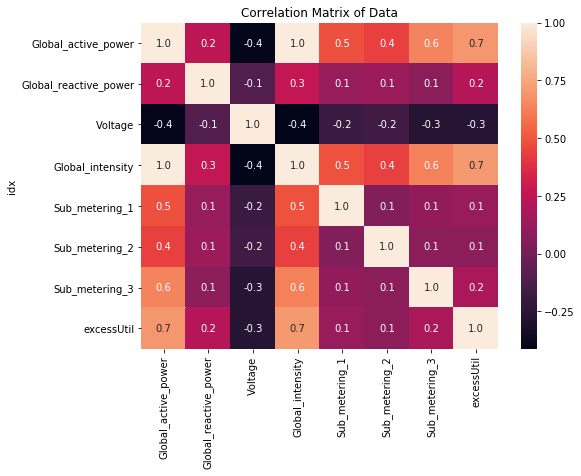

In [79]:
printHeader "Data Correlation"
corrMatrix:.ml.util.tab2df {x:flip 2_'x;x:x cor\:/: x;([]idx:key x),'value x} householdData
corrMatrix:corrMatrix[`:set_index]`idx;
plt[`:figure][`figsize pykw (8,6)];
sns[`:heatmap][corrMatrix;`annot pykw 1b;`fmt pykw ".1f"];
plt[`:title] "Correlation Matrix of Data";
plt[`:show][];

### Correlation Inference
From the simple correlation analysis we observe the following:

1. Intensity and Active power are exactly correlated. Hence from a feature perspective, we will only need one of them due to perfect collinearity.
2. Sub_metering though argued that 1 and 2 are of similar distribution, they are actually measuring distinct items in the household. Hence given the independence between the electrical appliances, the correlations are very low.
3. Active power is a strong indicator of the overall metering stats across all 3 sub meters. This can be seen from 40% to 60% correlation in data points.
4. As described in the simple inference, volatage is a formulation for current hence it is negatively correlated to active power.
5. ExcessUtil was primarily derived linearly from active power, hence this would explain the large correlation, we will only consider this feature after we can remove the linear relation which makes this feature redundant.
6. To improve on the features that we have, we will need to also consider non-linearly correlated features as we are limited to the small width of data collected.

## Problem Formulation

In this data problem, we do not have a specific target rather we are trying to characterise a distribution of variables and determine if there is anomalous activities. 

From this problem set, we can see that our features are limited to a simple study. However we can further extend the capabilities with FRESH, which is a feature extraction and selection technique. This algorithm is also provided in Kx's Machine Learning Library.

In creating our feature set we can note the features' distribution to determine conformity and detect potential anomaly.

In [86]:
featdict:.ml.fresh.getsingleinputfeatures[] / feature functions without hyperparams
show features:.ml.fresh.createfeatures[householdData;`Date;2_ cols householdData;featdict]

Date      | absenergy_Global_active_power absenergy_Global_reactive_power absenergy_Voltage absenergy_Global_intensity absenergy_Sub_metering_1 absenergy_Sub_metering_2 absenergy_Sub_metering_3 abs..
----------| -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..
2006.12.16| 4108.269                      6.952124                        2.210458e+07      75026.32                   0                        11264                    83230                    608..
2006.12.17| 10075.01                      54.45996                        8.302778e+07      180400.9                   69669                    123627                   231153                   126..
2006.12.18| 4826.452                      35.3234                         8.381744e+07      85356.16                   36753                    70265                    247016                   462..


In [91]:
printHeader "Count of feature"
count cols features

Count of feature


289


From the simplistic run of the FRESH algorithm for feature creation, we now have 289 features in each date. This is an overwhelming difference from the 8 features we started with.

However due to the overwhelming features, there is a need to clean out excess features through the selection algorithm which was proposed in the FRESH framework.

This framework utilises the concept of statistical significance. If a feature is determined to be statistically insignificant by the hypothesis testing framework, the feature will be dropped from the final analysis.

Due to the structure of aggregrating data sets into date, there was also a reduction of computation needed given that the vector has shrunk. Though there is a loss of information from the greater interval, pooled features tend to reduce outlier effect which might probably produce more accurate anomaly.

However since we do not have a target, there is no benchmark for the statistical analysis. Hence we will proceed forward in randomly selecting features and put it through the anomaly detection algorithms.

As a first level filter, we will remove all constant columns as low variance will not enable the learning algorithm.

In [98]:
printHeader "Count of feature with variance"
count cols varFeatures:.ml.util.dropconstant value features

Count of feature with variance


278


In [99]:
printHeader "Names of all Features created by Fresh"
{x!x}cols varFeatures

Names of all Features created by Fresh


absenergy_Global_active_power                 | absenergy_Global_active_power
absenergy_Global_reactive_power               | absenergy_Global_reactive_power
absenergy_Voltage                             | absenergy_Voltage
absenergy_Global_intensity                    | absenergy_Global_intensity
absenergy_Sub_metering_1                      | absenergy_Sub_metering_1
absenergy_Sub_metering_2                      | absenergy_Sub_metering_2
absenergy_Sub_metering_3                      | absenergy_Sub_metering_3
absenergy_excessUtil                          | absenergy_excessUtil
abssumchange_Global_active_power              | abssumchange_Global_active_power
abssumchange_Global_reactive_power            | abssumchange_Global_reactive_power
abssumchange_Voltage                          | abssumchange_Voltage
abssumchange_Global_intensity                 | abssumchange_Global_intensity
abssumchange_Sub_metering_1                   | abssumchange_Sub_metering_1
abssumchange_Sub_metering_

### Random Selection of Features for Anomaly

With `278` features, there can be countless methodology to run through anomaly detection algorithms. In a research paper, there might be time to consider all features. However for the sake of discussion through a simple formed problem, a random subset of features will be used in this notebook.

### Choice of Algorithms

Now that the data has been settled, it is important to pick the anomaly detection algorithms which will shed light into the consumption data.

This can be easily replicated across to other scenarios and data type. 
For example
    
    1. Detect potential cyber attack within a computer system
    2. Detect change in weather condition which might alert in catastrophic disaster
    3. Detect manufacturing defect in sensors or high volume manufacturing plants

#### Recurrent Neural Network

The recurrent neural network allows building of a forward looking time series prediction model by allowing the model to learn from the input data. Through the recurrent feedback effect, trends are being picked up and this allows us to detect an anomaly. An anomaly score can be determined from the residual between the actual and what is predicted from the model.
If the `residual is large`, the likelihood of it being an `anomaly is large`.

#### ARIMA Deviation

Facebook created prophet which uses a additive regression model[$^2$](https://towardsdatascience.com/anomaly-detection-def662294a4e). Through prophet, users can easily push a time series and the best model will be trained. The outcome model is useful in detecting anomalies as it will assume various nodes of distribution with its mean and expected deviation, with yhat_lower and yhat_higher, we are able to build a boolean indicator if actual value is beyond the confidence interval. `Actual large deviations will be flagged as an anomly`.

#### Clustering

Instead of modelling the trends and pattern, a simple statistical deviation can be adopted and assumed of the data. Hence `large deviation by k factor can be benchmarked against a distribution` to determine an anomaly. This is performed with clustering algorithms and the choice of algorithm in this paper is the OneClassSVM which uses support vector machine to find a support boundary from a training set and potentially clustering outlier/anomaly in future data set.

<sup>2: Anomaly Detection- Key Feature</sup>

In [127]:
//For reproducibility, we set the random seedValue to 4
seedValue:4
system "S ",string seedValue
printHeader "Random Selected Features"
show randFeatures:-10?cols varFeatures
printNewLine`
printHeader "Finalised Features"
5#anomalyFeatures:(key features),'?[varFeatures;();0b;{x!x}randFeatures]
trainSet:(t:`int$0.8*count anomalyFeatures)#anomalyFeatures
testSet:(neg count[anomalyFeatures]-t)#anomalyFeatures

//remove Boolean from prediction
booleanFeatureRemover:{(exec c from meta[x] where t ="b") _ x}
trainSet:booleanFeatureRemover trainSet
testSet:booleanFeatureRemover testSet

last trainSet
first testSet

Random Selected Features
`firstmax_Global_intensity`kurtosis_Sub_metering_2`abssumchange_Sub_metering_2`lintrend_Global_reactive_power_stderr`countbelowmean_Sub_metering_2`lintrend_Sub_metering_2_rval`vargtstddev_Global_in..


Finalised Features


Date       firstmax_Global_intensity kurtosis_Sub_metering_2 abssumchange_Sub_metering_2 lintrend_Global_reactive_power_stderr countbelowmean_Sub_metering_2 lintrend_Sub_metering_2_rval vargtstddev..
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------..
2006.12.16 0.0530303                 35.23575                286                         4.195264e-05                          345                           -0.2846255                   1          ..
2006.12.17 0.3770833                 14.67404                1319                        6.52264e-06                           1301                          -0.2099275                   1          ..
2006.12.18 0.8131944                 18.27117                908                         6.921719e-06                          1257                          0.3437149                    1          ..


Date                                 | 2010.02.11
firstmax_Global_intensity            | 0.8041667
kurtosis_Sub_metering_2              | 3.999584
abssumchange_Sub_metering_2          | 142f
lintrend_Global_reactive_power_stderr| 4.623375e-06
countbelowmean_Sub_metering_2        | 1177i
lintrend_Sub_metering_2_rval         | 0.05364624
perrecurtoallval_excessUtil          | 0.7513889
sumrecurringval_Global_reactive_power| 15.708
perrecurtoalldata_Sub_metering_3     | 0.4615385


Date                                 | 2010.02.12
firstmax_Global_intensity            | 0.4881944
kurtosis_Sub_metering_2              | 4.487668
abssumchange_Sub_metering_2          | 136f
lintrend_Global_reactive_power_stderr| 6.222979e-06
countbelowmean_Sub_metering_2        | 1192i
lintrend_Sub_metering_2_rval         | 0.1149275
perrecurtoallval_excessUtil          | 0.71875
sumrecurringval_Global_reactive_power| 18.144
perrecurtoalldata_Sub_metering_3     | 0.5454545


## ARIMA Deviation
Inspiration was taken from H.Rechavia[$^3$](https://towardsdatascience.com/using-open-source-prophet-package-to-make-future-predictions-in-r-ece585b73687), which established extensively the simplistic use case of prophet with time series data.

With the `10` features, we will feed into prophet each of the features along with 1 feature of excess utility. Through this exercise, the simplistic power of Prophet is paired with embedpy to simplify a simple anomaly detection problem

<sup>3: Using Open Source Prophet Package to Make Future Predictions in R</sup>

In [162]:
//There is a need to convert date into numpy dateTime
pydates:np[`:array][<;] {dateTime[>;x 0;x 1;x 2]} each "J"$"." vs' string trainSet[`Date];
data:enlist[`Date] _ trainSet;

//Declaration of prophetForecaster function
//Placeholder for result

prophetForecaster:{ 
    label:x 0;
    x:x 1;
    printHeader "Prophet Forecaster for: ",.Q.s label;
    data:pd[`:DataFrame] `ds`y!(pydates;x);
    data[`:plot][`figsize pykw (12;8)];
    plt[`:show][];
    model:Prophet[pykwargs `interval_width`daily_seasonality!(0.95;1b)];
    model:model[`:fit][data];
    futureDates:model[`:make_future_dataframe][`periods pykw count testSet];
    forecast:model[`:predict][futureDates];
    enlist[label]!enlist forecast
 }

Prophet Forecaster for: `firstmax_Global_intensity



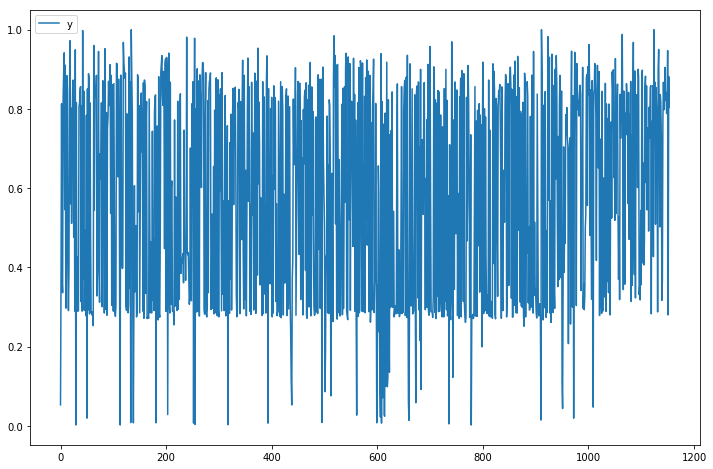

Initial log joint probability = -76.9927
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       991.592   0.000381907       72.0601      0.3253      0.8952      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       991.627   2.67374e-05       77.5913    3.06e-07       0.001      251  LS failed, Hessian reset 
     199       991.628   2.22267e-07       76.5396           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       991.628   3.37194e-06       92.2843   4.213e-08       0.001      346  LS failed, Hessian reset 
     222       991.628   7.58249e-08       66.5143           1           1      366   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Prophet Forecaster for: `kurtosis_Sub_metering_2



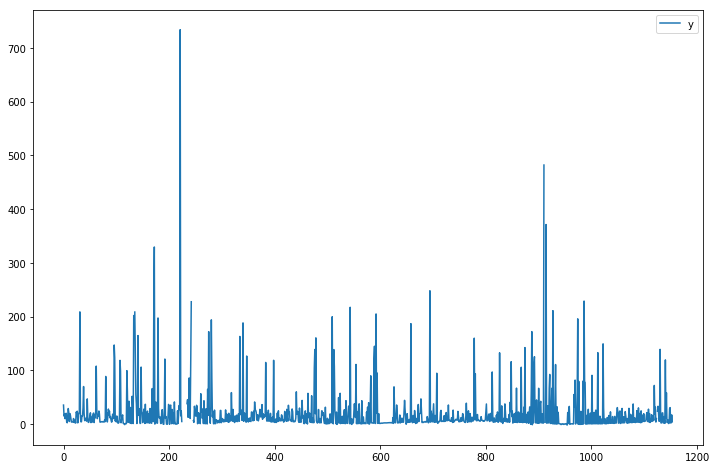

Initial log joint probability = -4.17767
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       2650.54   1.75166e-07       75.1886      0.5819      0.5819      116   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Prophet Forecaster for: `abssumchange_Sub_metering_2



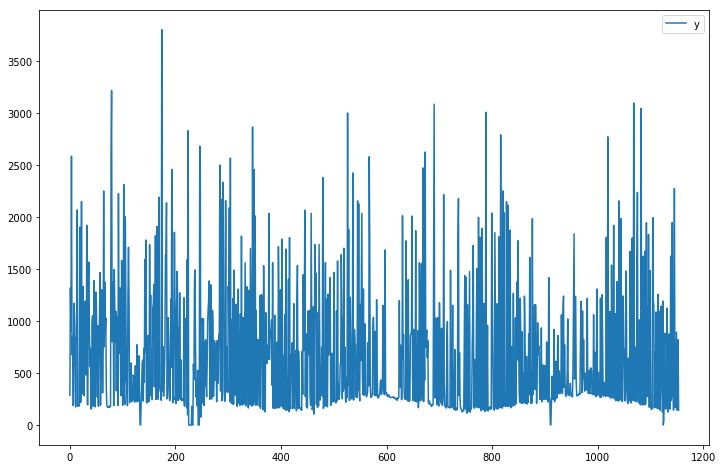

Initial log joint probability = -24.6366
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1605.28   3.82495e-06       74.0753           1           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188        1605.3   9.48895e-06       63.1442   1.332e-07       0.001      309  LS failed, Hessian reset 
     199        1605.3   1.58665e-05       68.7491           1           1      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216        1605.3   6.21966e-08       62.2368      0.2427      0.2427      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Prophet Forecaster for: `lintrend_Global_reactive_power_stderr



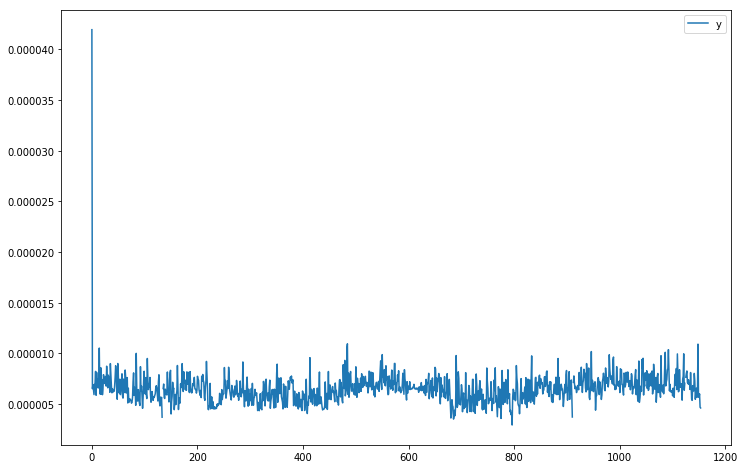

Initial log joint probability = -133.866
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       3341.81    0.00351873       588.778      0.4072      0.4072      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       3341.94   3.95502e-05        140.47   2.334e-07       0.001      185  LS failed, Hessian reset 
     132        3342.3   4.94414e-05       155.716   5.062e-07       0.001      257  LS failed, Hessian reset 
     159       3342.52   2.35656e-05       59.6123    1.53e-07       0.001      337  LS failed, Hessian reset 
     199       3342.75    0.00305572       272.298           1           1      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       3343.16   2.84607e-05       91.8088   1.714e-07       0.001      507  LS failed, Hessian reset 
     283       3343.22   0.000107767       217.088   7.251e-07   

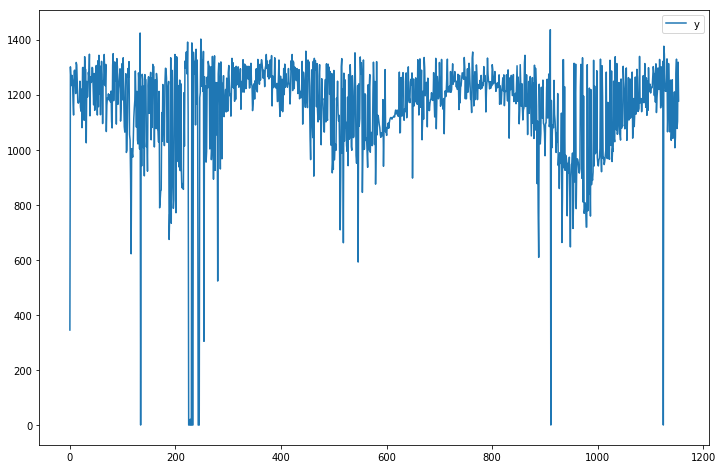

Initial log joint probability = -72.258
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1889.97    0.00598682       148.901      0.3622           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       1892.16   0.000406778       96.0914   5.073e-06       0.001      194  LS failed, Hessian reset 
     199       1892.75   0.000105029       85.0767      0.8344      0.8344      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       1892.83   6.90337e-08         77.52      0.3848           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Prophet Forecaster for: `lintrend_Sub_metering_2_rval



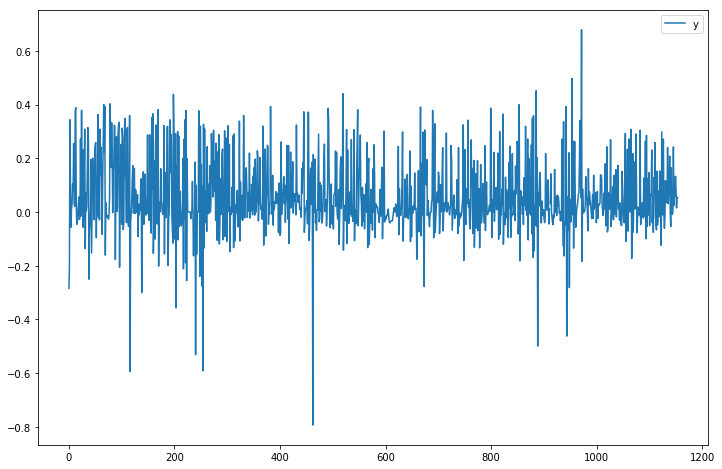

Initial log joint probability = -56.9001
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1473.74    0.00126525       165.824       0.345      0.9373      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163        1475.7   1.77889e-05       65.7717   2.457e-07       0.001      251  LS failed, Hessian reset 
     192       1475.71   9.82296e-07       70.1112   1.392e-08       0.001      332  LS failed, Hessian reset 
     197       1475.71   1.34291e-07       52.0999       1.018      0.2829      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Prophet Forecaster for: `perrecurtoallval_excessUtil



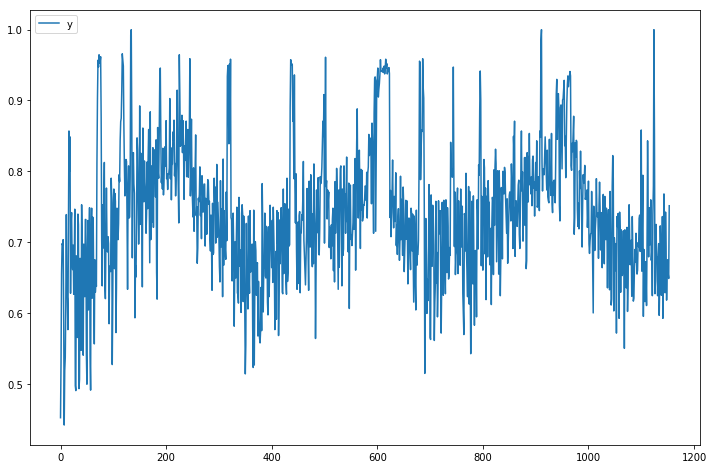

Initial log joint probability = -22.5935
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       2500.96   0.000157032       126.746   1.016e-06       0.001      167  LS failed, Hessian reset 
      99       2501.24   0.000225498       65.8153       1.308      0.3714      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       2501.43   0.000146927       105.164   8.295e-07       0.001      273  LS failed, Hessian reset 
     199       2501.51   1.05072e-06       71.0705      0.1646      0.1646      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       2501.51   5.96912e-08       58.2037      0.2397      0.2397      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Prophet Forecaster for: `sumrecurringval_Global_reactive_power



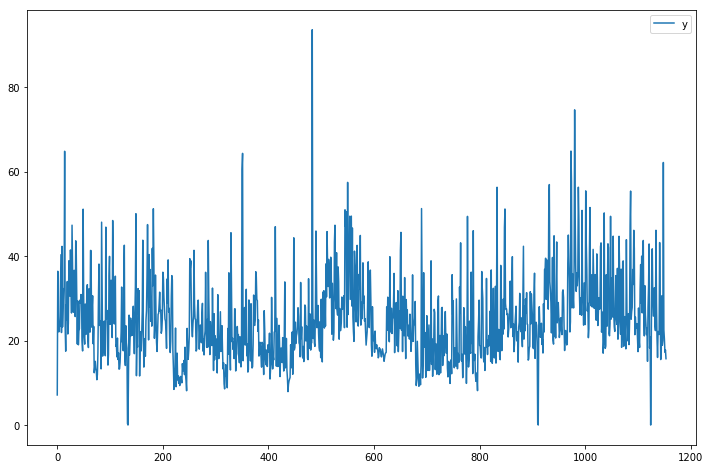

Initial log joint probability = -20.4226
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2186.96   0.000168871       65.2373       0.629       0.629      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       2187.72   0.000278184       140.509   2.087e-06       0.001      171  LS failed, Hessian reset 
     168       2190.09   0.000669105       226.257   6.687e-06       0.001      286  LS failed, Hessian reset 
     199       2190.63    0.00122015       58.3174     0.05728           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       2190.82   0.000997327       208.395   1.358e-05       0.001      375  LS failed, Hessian reset 
     273       2190.89   1.09464e-06       52.4558   1.699e-08       0.001      501  LS failed, Hessian reset 
     280       2190.89    4.3194e-08       65.1091     0.02638   

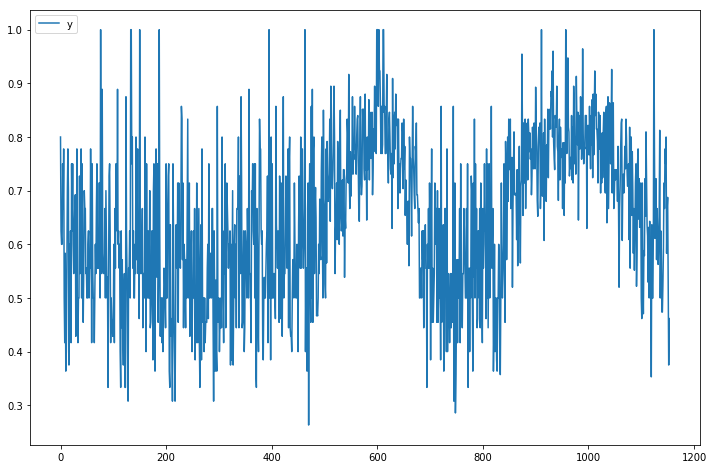

Initial log joint probability = -26.0859
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1827.75    0.00634306       266.313      0.5177      0.5177      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1832.11   8.12949e-05        67.724       2.139      0.5919      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       1832.12   5.06543e-05       80.5204   7.725e-07       0.001      301  LS failed, Hessian reset 
     255       1832.12   1.33528e-07        60.466           1           1      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


In [167]:
res:raze prophetForecaster each flip {(key[x];value[x])}flip data

In [260]:
// Visualise the predicted output of prophet for those who have not used prophet before
display res`firstmax_Global_intensity

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2006-12-16,0.156235,0.094592,1.074026,0.156235,0.156235,0.441295,0.441295,0.441295,0.413609,0.413609,0.413609,0.037601,0.037601,0.037601,-0.009916,-0.009916,-0.009916,0.0,0.0,0.0,0.597530
1,2006-12-17,0.156196,0.096609,1.128921,0.156196,0.156196,0.459979,0.459979,0.459979,0.413609,0.413609,0.413609,0.054706,0.054706,0.054706,-0.008337,-0.008337,-0.008337,0.0,0.0,0.0,0.616175
2,2006-12-18,0.156157,0.088768,1.095046,0.156157,0.156157,0.412370,0.412370,0.412370,0.413609,0.413609,0.413609,0.005038,0.005038,0.005038,-0.006278,-0.006278,-0.006278,0.0,0.0,0.0,0.568527
3,2006-12-19,0.156118,0.065961,1.044875,0.156118,0.156118,0.409439,0.409439,0.409439,0.413609,0.413609,0.413609,-0.000411,-0.000411,-0.000411,-0.003760,-0.003760,-0.003760,0.0,0.0,0.0,0.565556
4,2006-12-20,0.156079,0.033095,1.009082,0.156079,0.156079,0.359698,0.359698,0.359698,0.413609,0.413609,0.413609,-0.053100,-0.053100,-0.053100,-0.000811,-0.000811,-0.000811,0.0,0.0,0.0,0.515777
5,2006-12-21,0.156039,0.053570,1.082400,0.156039,0.156039,0.403689,0.403689,0.403689,0.413609,0.413609,0.413609,-0.012450,-0.012450,-0.012450,0.002530,0.002530,0.002530,0.0,0.0,0.0,0.559728
6,2006-12-22,0.156000,0.044678,1.059245,0.156000,0.156000,0.388440,0.388440,0.388440,0.413609,0.413609,0.413609,-0.031385,-0.031385,-0.031385,0.006216,0.006216,0.006216,0.0,0.0,0.0,0.544441
7,2006-12-23,0.155961,0.120335,1.138536,0.155961,0.155961,0.461406,0.461406,0.461406,0.413609,0.413609,0.413609,0.037601,0.037601,0.037601,0.010195,0.010195,0.010195,0.0,0.0,0.0,0.617367
8,2006-12-24,0.155922,0.143144,1.144850,0.155922,0.155922,0.482721,0.482721,0.482721,0.413609,0.413609,0.413609,0.054706,0.054706,0.054706,0.014406,0.014406,0.014406,0.0,0.0,0.0,0.638643
9,2006-12-25,0.155882,0.083189,1.079326,0.155882,0.155882,0.437432,0.437432,0.437432,0.413609,0.413609,0.413609,0.005038,0.005038,0.005038,0.018784,0.018784,0.018784,0.0,0.0,0.0,0.593314


{[f;x]embedPy[f;x]}[foreign]enlist


In [213]:
printHeader "Calculate deviate against true value for anomaly detection"
printNewLine`
//note that all the tables are stored with the training set for continuity purpose;
deviationExtractor:{
    //extract Data
    data:.ml.util.df2tab res[x];
    data:update date:anomalyFeatures[`Date], actual:anomalyFeatures[x] from data;
    data:update anomalyValue:not actual within' (yhat_lower,'yhat_upper) from data;
    printSimpleHeader "Dates predicted as anomaly ",.Q.s1 x;
    show dates:exec date from data where anomalyValue;
    printNewLine`;
    dates
 }
allDates:deviationExtractor each 1_cols booleanFeatureRemover anomalyFeatures;

Calculate deviate against true value for anomaly detection


Dates predicted as anomaly `firstmax_Global_intensity
_____________________________________________________


2006.12.16 2007.01.14 2007.02.04 2007.04.08 2007.04.28 2007.05.03 2007.07.07 2007.08.25 2007.08.28 2007.10.29 2008.01.13 2008.04.24 2008.05.11 2008.06.29 2008.10.05 2008.10.19 2008.12.21 2008.12.28..


Dates predicted as anomaly `kurtosis_Sub_metering_2
___________________________________________________


2007.01.16 2007.02.16 2007.03.22 2007.03.23 2007.04.02 2007.04.28 2007.04.29 2007.04.30 2007.05.01 2007.05.06 2007.06.05 2007.06.06 2007.06.13 2007.07.25 2007.07.29 2007.07.30 2007.07.31 2007.08.01..


Dates predicted as anomaly `abssumchange_Sub_metering_2
_______________________________________________________


2006.12.19 2006.12.30 2007.01.04 2007.01.07 2007.02.18 2007.03.04 2007.03.05 2007.03.28 2007.03.31 2007.06.03 2007.06.08 2007.06.27 2007.06.28 2007.07.02 2007.07.26 2007.07.28 2007.08.19 2007.08.20..


Dat

In [258]:
printHeader "Anomaly Date Matrix"
show 3#anomalyMatrix:group raze allDates
printNewLine`

Threshold:3;
printHeader "Anomaly Date with commonality threshold: " ,string Threshold
commonAnomaly:count each anomalyMatrix
show (!). reverse (commonAnomaly anomalyDate;anomalyDate:{key[x] where Threshold<value x}commonAnomaly)

Anomaly Date Matrix
2006.12.16| 0 198 253 316 396 486
2007.01.14| 1 403
2007.02.04| ,2


Anomaly Date with commonality threshold: 3
2006.12.16| 6
2007.04.28| 6
2009.06.13| 6
2010.03.20| 4
2010.09.25| 4
2010.11.21| 4
2007.04.29| 7
2009.06.14| 7
2010.01.13| 7
2010.08.18| 6
2010.08.19| 5
2010.08.20| 5
2010.08.21| 6
2010.09.26| 6
2010.09.27| 6
2007.03.05| 4
2008.06.15| 4
2008.11.05| 4
2010.09.28| 4


### Findings from ARIMA Deviation

With embedPy, we are able to build predictive model from strong python packages. In this example we used prophet which is created by Facebook which helps in predictive time series modelling. Removing the market unpredictiveness of the financial markets, the additive regressive model is well suited to time series deviod of emotions. In this case we utilise prohpet for electrical data but this is transferrable to high seasonality time series such as sales forecasting.

With Prophet, account for additional regressors and holiday can be done but was omitted in this exercise. As a unsupervised learning pipeline, we are able to build a more complex algorithm around prophet and the FRESH framework. With vast amount of features we can select what works from research and finally creating a powerful anomaly detection model that can lower cost and increase detection rate.

`WARNING: The analysis preformed above is not optimised and by design the prediction can only occur end of day (feature creation by aggregation)`

In our predicted model, we see that in 2010 which is the out of sample dates, a greater number of anomaly is predicted. This can be attributed to the poor selection of features (obvious from the feature plots) but can also be attributed to high variation when sampling out of sample. This can be improved when we reduce the time bracket and only predict forward in smaller time step instead of days.

Given the nature of some of the features, it expected that it is hard to predicted them forward in a time series context. 
Instead we can also tune the problem to the raw features to determine if there is any deviation and this has a more robust pattern that can be picked up by the additive regressor model.

## LSTM Recurrent Neural Network
Inspiration was taken from J.Brown[$^4$](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/), which illustrated the simple use case of LSTM with time series data. In Recurrent Neural Network, we are able to feed in features and make the network pick up any possible patterns. This is a very powerful model and it can pick up subtilities which humans are unable to. However bearing must be established that overfitting is usually the largest concern in building a neural network.

In order to perform anomaly detection, a deviation score is needed to determine if at a particular time point, an anomaly is present. Against a threshold, when the deviation exceeds, at that particular time point an anomaly is detected.

### Framing the problem

With LSTM, there is a need to feature engineer the time lags and frame the time series into a supervised learning problem into the future. 

For example: $y_{(t)} = w*y_{(t-1)} + \beta$

Since the features are in the current time, we can simply use `next` to create future time features and perform the same analysis which was performed with prophet.

It might be better perform a multivariate forecasting targetting a specific feature that is to be forecasted forward. However for consistency and comparison of results against the additive regressive model, the LSTM will take the same approach by performing a univariate time series forecasting for each feature created by the FRESH framework.

<sup>4: Multivariate Time Series Forecasting with LSTMs in Keras</sup>

In [368]:
//write a function that creates lag on columns passed in
minMaxScaler:{-[2*(x - min x)% max[x]-min x;1]}
inverseMinMax:{z+(+[1;x]*y-z)%2}
/@x is scaled data
/@y is max of pre scaled
/@z is min of post scaled

lagCreation:{
    yt:`$string[y],/:("_t1";"_diff1";"_diff1_t1";"_diff1_scaled";"_diff1_t1_scaled");
    //create lag terms
    data:?[x;();0b;(y;yt 0)!(y;(next;y))];
    data:![data;();0b;enlist[yt 1]!enlist (-;yt 0;y)];
    data:![data;();0b;enlist[yt 2]!enlist (next;yt 1)];
    totalNo:count data;
    //remove row that will have nulls due to forward looking
    data:-2 _ data;
    data:`test`train!((neg totalNo-trainCount)#data;(trainCount:`int$*[z;totalNo])#data);
    //scaling of data
    maxMin:()!();
    maxMin[`train]:(max;min) @\:data[`train]yt 2;
    maxMin[`test]:(max;min) @\:data[`test]yt 2;
    data[`train]:![data[`train];();0b;(yt 3 4)!((minMaxScaler;yt 1);(minMaxScaler;yt 2))];
    data[`test]:![data[`test];();0b;(yt 3 4)!((minMaxScaler;yt 1);(minMaxScaler;yt 2))];
    :`data`maxMin!(data;maxMin)
 }

In [406]:
//Generate LSTM Model
model:Sequential[];
model[`:add][LSTM[4;`input_shape pykw .p.eval"(1,1)";`return_sequences pykw 1b]];
model[`:add][Dropout[0.25]];
model[`:add][LSTM[8]];
model[`:add][Dense[1]];
model[`:compile][pykwargs `loss`optimizer!`mean_squared_error`adam];
model[`:summary][];

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 1, 4)              96        
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 4)              0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 8)                 416       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 9         
Total params: 521
Trainable params: 521
Non-trainable params: 0
_________________________________________________________________


In [407]:
splitRatio:0.8
//Example of using firstmax_Global_intensity
trainLagFeatures:.[lagCreation;(anomalyFeatures;`firstmax_Global_intensity;splitRatio)]
x:(np[`:array]trainLagFeatures[`data;`train;`firstmax_Global_intensity_diff1_scaled])[`:reshape][1154;1;1]
y:np[`:array]trainLagFeatures[`data;`train;`firstmax_Global_intensity_diff1_t1_scaled]

model[`:fit][x;y;`epochs pykw 20;`batch_size pykw 1;`verbose pykw 2;`shuffle pykw 0b];

Epoch 1/20
 - 8s - loss: 0.1095
Epoch 2/20
 - 7s - loss: 0.1105
Epoch 3/20
 - 7s - loss: 0.1087
Epoch 4/20
 - 7s - loss: 0.1096
Epoch 5/20
 - 8s - loss: 0.1115
Epoch 6/20
 - 8s - loss: 0.1110
Epoch 7/20
 - 7s - loss: 0.1097
Epoch 8/20
 - 7s - loss: 0.1112
Epoch 9/20
 - 8s - loss: 0.1083
Epoch 10/20
 - 7s - loss: 0.1097
Epoch 11/20
 - 7s - loss: 0.1096
Epoch 12/20
 - 7s - loss: 0.1096
Epoch 13/20
 - 8s - loss: 0.1092
Epoch 14/20
 - 7s - loss: 0.1090
Epoch 15/20
 - 7s - loss: 0.1074
Epoch 16/20
 - 7s - loss: 0.1117
Epoch 17/20
 - 7s - loss: 0.1087
Epoch 18/20
 - 7s - loss: 0.1101
Epoch 19/20
 - 8s - loss: 0.1117
Epoch 20/20
 - 7s - loss: 0.1109


{[f;x]embedPy[f;x]}[foreign]enlist


In [428]:
x_test:(np[`:array]trainLagFeatures[`data;`test;`firstmax_Global_intensity_diff1_scaled])[`:reshape][288;1;1]
yPredict:raze model[`:predict][x_test]`
yPredict:inverseMinMax[yPredict] . trainLagFeatures[`maxMin;`test]

In [438]:
//Normalise difference against predicted value for absolute difference
printHeader "Normalised Difference"
show normalisedPredict:abs -[trainLagFeatures[`data;`test;`firstmax_Global_intensity_diff1_t1];yPredict]%yPredict
printNewLine`
threshold:17
printSimpleHeader "Anomaly Dates when threshold set at ",string threshold
show testSet[`Date] where normalisedPredict > threshold

Normalised Difference
18.46271 0.6425592 3.664527 1.40945 1.091218 3.932137 3.143289 8.254316 0.9954235 5.273806 2.494971 13.35933 0.6950334 1.151179 16.82742 0.3191018 2.606109 1.98073 0.3780293 11.56532 9.251493 0.372..


Anomaly Dates when threshold set at 17
______________________________________


2010.02.12 2010.03.16 2010.03.20 2010.05.24 2010.06.27 2010.07.11 2010.07.13 2010.08.01 2010.08.23 2010.09.16 2010.10.13 2010.10.17 2010.10.25 2010.11.04 2010.11.06


## Findings from LSTM
With embedPy, we are able to build recurrent neural network for time series prediction. In this example we used Keras which is a wrapper around TensorFlow in building deep neural network. With Keras, complicated networks can be created and LSTM is well suited to time series deviod of emotions in learning patterns through time. 

However fine tuning of the LSTM has not been perform in the interest of time. The work here is only a proof of concept which we are unable to validate against, but this is also the basis of unsupervised problems.

In building an anomaly detection around LSTM, an arbitary threshold has to be specified against an absolute difference. The choice of standard deviation can also be used but we have to be careful with the choice of changing standard deviation through time. Hence the simple absolute deviation was picked instead. 

In our LSTM predicted model, we are only interested in dates out-of-sample and it has `15` anomaly triggered. Dates are pretty sparse and scattered. There is no identifiable pattern and this is expected of an anomaly. However it should be noted that the appearance of anomaly is easily affected by the choice of theshold. With a lower threshold, huge number of anomaly will be trigger by this simple algorithm. Likewise with a higher threshold, no anomaly will be detected.

Given the complexity in training neural network compared to prophet, the multiple features training was omitted but the logic can be replicated across all the `FRESH` features.

Despite the lacking in understanding of the created features, and difficulty to predict them forward in a time series context, these features stand to have huge potential in designing a use case algorithm.

# Clustering

Given the created features, there is also the ability to use unsupervised learning technique to find anomalies. This is the classical approach in using non-parametric algorithm. In this section, we will use k means clustering on the aggregrated `FRESH Features`. Despite the need to determine k arbitarily, this can be automated and is not the interest in this study. 

A better approach in anomaly detection will utilise sliding window and clustering for commonality before detection is performed. However in this exercise, we will utilise the `OneClassSVM` which is an unsupervised learning algorithm in detecting outlier.
The algorithm uses the Support Vector Machine's ability to draw a line around the data and prune out the outlier which we can identify as anomalies.

This can be performed in sklearn with just a few lines of code and the pipeline is simplified for kdb+ data with embedPy.

In [463]:
classifier:{model:OneClassSVM[];
    //We will reuse the trainingSet created for prophet.
    //Here we will train the clustering algorithm with oneClassSVM, from here we will predict on the future value if it is an anomaly
    //Again we are concern with future anomaly detection
    -1"Anomaly Detection for Feature: ",.Q.s x;
    model[`:fit](np[`:array]0^trainSet x)[`:reshape][-1;1];
    testSet[`Date] where -1 = model[`:predict;<](np[`:array]0^testSet x)[`:reshape][-1;1]
    }

printHeader"Anomaly Dates predicted by OneClassSVM";
show -1?svmAnomalyDates:classifier each cols enlist[`Date] _ trainSet

printHeader "Anomaly Date Matrix"
show 3#anomalyMatrixSVM:group raze svmAnomalyDates
printNewLine`

Threshold:7;
printHeader "Anomaly Date with commonality threshold: " ,string Threshold
commonAnomalySVM:count each anomalyMatrixSVM
show (!). reverse (commonAnomalySVM svmAnomalyDates;svmAnomalyDates:{key[x] where Threshold<value x}commonAnomalySVM)

Anomaly Dates predicted by OneClassSVM
Anomaly Detection for Feature: `firstmax_Global_intensity

Anomaly Detection for Feature: `kurtosis_Sub_metering_2

Anomaly Detection for Feature: `abssumchange_Sub_metering_2

Anomaly Detection for Feature: `lintrend_Global_reactive_power_stderr

Anomaly Detection for Feature: `countbelowmean_Sub_metering_2

Anomaly Detection for Feature: `lintrend_Sub_metering_2_rval

Anomaly Detection for Feature: `perrecurtoallval_excessUtil

Anomaly Detection for Feature: `sumrecurringval_Global_reactive_power

Anomaly Detection for Feature: `perrecurtoalldata_Sub_metering_3

2010.02.18 2010.02.22 2010.02.23 2010.02.26 2010.02.28 2010.03.09 2010.03.11 2010.03.14 2010.03.16 2010.03.18 2010.03.20 2010.03.21 2010.03.22 2010.03.25 2010.03.29 2010.04.01 2010.04.03 2010.04.06..
Anomaly Date Matrix
2010.02.18| 0 259 450 734 932 1212
2010.02.22| 1 118 261 454 936
2010.02.23| 2 119 262 455 737 937 1383


Anomaly Date with commonality threshold: 7
2010.05.09| 8
2010.06

## Findings from Clustering
Finally we show that in embedPy, there a plentiful of machine learning tools in python which can be added for versatility. This is easily shown by wrapping q functions with sklearn which made a powerful wrapper package even greater. 

With a simple call of sklearn's fit and predict, we are able fit the oneClassSVM to the training data and potentially label future test data as inlier or outliers. When the features created by FRESH are classified as an outlier, there is a potential for an anomaly in that particular date.

Again, we maintain an arbitrary threshold against the sensitive algorithm to prune out excessive outlier detection from the 10 features. With the choice of `7`, the propose algorithm pipeline produced `15` dates which potentially have anomalous electrical consumption.

Likewise with all the machine learning tools used in this paper, no optimisation and fine tuning were performed. This is complicated with low understanding of electrical data and knowing which feature works best. However this paper tries to seek out potential use cases that has been enabled by embedPy through large number of python packages.

`WARNING: The analysis preformed above is not optimised and by design the prediction can only occur end of day (feature creation by aggregation)`

In our predicted model, are only looking at the out of sample dates and there is no explicit patterns. However, arguably, we can say that when a date is highlighted as an anomaly, close by dates are likely to be highlight as anomaly by this algorithm. 
Also with the default settings of oneClassSVM, multiple dates were easily labeled as anomalous. Hence a strict threshold was applied to filter the large number of dates to a reasonable standpoint. This has to be arbitarily set without looking at the data when it is applied into a business setting. 

From a comparison standpoint against prophet, this methodology seems to suggest more anomalies and this could be a result of no fine-tuning. It can be extracted that clustering on various type of features would definitely need some level of fine tuning instead of the generic settings.

# Conclusion

As demostrated in this notebook, there is value adding effect from the `FRESH` framework in feature engineering for machine learning problems.

This allow the utilisation of unconventional exploratory features in predicting anomaly and potentially for other use cases.

From the various findings, we show that anomaly by design requires subject matter expertise as different algorithm will produce different results and there is low ability to validate against an unsupervised problem. However this is definitely a space where continous research, trial and error will eventually empower the study into a particular data problem.

Finally, it is also shown that embedPy has greatly empower kdb+ users to not only be restricted to feature/data engineering. q wrapped over python allows convenient wrapper to build machine learning models and algorithm. This can be used to build a holistic application where kdb+ database empowers the application.